In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/irishlyricseof/irish-lyrics-eof.txt


In [2]:
#Load a text datasets
# Import necessary libraries
import os

#path
file_path = '/kaggle/input/irishlyricseof/irish-lyrics-eof.txt'

# Check if the file exists
if os.path.exists(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()
    
    #print some contents
    print(content[:200])
else:
    print(f"The file {file_path} does not exist.")


Come all ye maidens young and fair
And you that are blooming in your prime
Always beware and keep your garden fair
Let no man steal away your thyme
For thyme it is a precious thing
And thyme brings al


**IMPROVING THE DATA**

There’s a small trick that you can use to extend the size of the dataset without adding any new songs, called **windowing the data.** In the context of text generation, "windows" typically refer to subsequences of words or tokens in a larger text corpus. The goal is to extract these windows to create training samples for a text generation model. There are two types of window which are; overlapping and non-overlapping windows. 

**Overlapping Windows**

Overlapping windows involve creating subsequences where each window includes some of the same data points as the previous window.The windows overlap, sharing common elements.

Overlapping windows are often used in tasks where the order and continuity of words are important.
Useful for capturing temporal dependencies and relationships in sequential data, such as language modeling and sequence-to-sequence tasks.

**Non-Overlapping Windows**


Non-overlapping windows involve creating subsequences where each window is disjoint and does not share data points with adjacent windows. The windows are consecutive and non-overlapping.

Non-overlapping windows are simpler and may be used when the order of words is less critical, and the context within each window is sufficient for the task.
Commonly used in tasks like text classification or document categorization.

In [3]:
#Create Non-Overlapping Windows

window_size = 10
sentences = []
alltext = []

#Load the text
data = content
corpus = data.lower()
words = corpus.split(" ")
range_size = len(words) - window_size

for i in range(0, range_size):
    this_sentence = ""
    for j in range(0, window_size - 1):
        current_word = words[i + j]
        this_sentence = this_sentence + current_word + " "

    sentences.append(this_sentence)


In [4]:
#sentences

In [5]:
#Tokenize the lyrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

#Initialize the Tokenize
tokenizer = Tokenizer()
#Load the text
data = sentences

#corpus = data.lower().split("\n")
corpus = data
tokenizer.fit_on_texts(data)
total_words = len(tokenizer.word_index) + 1

#Turning a sequence into a number of input sequences
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        
#Once you have these input sequences, you can pad them into a regular shape

#Find the longest sentence in the input sequences, and pad everything to that length.
max_sequence_len = window_size

#Let's use pre-padding
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences)

#Turning the padded sequences into features (x) and labels (y)
xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]



[[   0    0    0 ...    0   54   12]
 [   0    0    0 ...   54   12  101]
 [   0    0    0 ...   12  101 2689]
 ...
 [   0   22   14 ...  797  151  360]
 [  22   14   43 ...  151  360   47]
 [  14   43  128 ...  360   47  105]]


In [6]:

#Encode the labels into a set of Ys that can be used for train
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
#print(ys)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           21520     
                                                                 
 bidirectional (Bidirection  (None, None, 18)          1296      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 18)                2016      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2690)              51110     
                                                                 
Total params: 75942 (296.65 KB)
Trainable params: 75942 (296.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
5

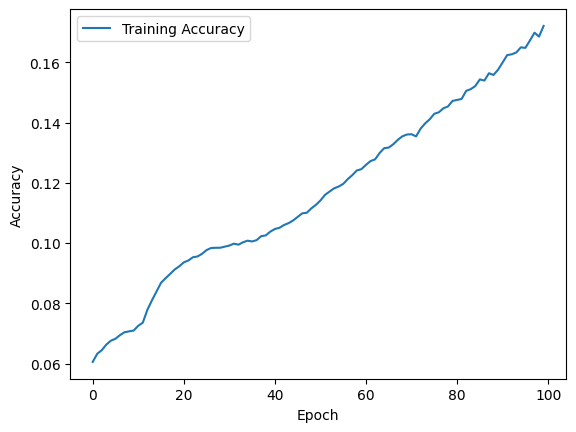

In [7]:
#One way that you can improve the model is to change its architecture, using multiple stacked LSTMs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

#Model architecture
model = Sequential()
model.add(Embedding(total_words, 8))
#First stacked LSTMs
model.add(Bidirectional(LSTM(max_sequence_len-1, return_sequences='True')))
#Second stacked LSTMs
model.add(Bidirectional(LSTM(max_sequence_len-1)))
model.add(Dense(total_words, activation='softmax'))


#Model compiling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(xs, ys, epochs=100, verbose=1, batch_size=200)

# Plot training accuracy
import matplotlib.pyplot as plt



# Plot training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
# Save the model
import tensorflow as tf

#This will save the model, including its architecture, optimizer, and learned weights
model.save("/kaggle/working/modified_iris_lyrics_model")

## Load the model
modified_loaded_model = tf.keras.models.load_model("/kaggle/working/modified_iris_lyrics_model")

In [9]:
#predicting the next words

#Start with a phrase that the network has already seen, “in the town of athy”
seed_text = "in the town of athy"

#Tokenize the seed
token_list = tokenizer.texts_to_sequences([seed_text])[0]

#Pad that sequence to get it into the same shape as the data used for training
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

#predict the next word
predicted = np.argmax(modified_loaded_model.predict(token_list), axis=-1)
print(predicted)

#print a word predicted
for word, index in tokenizer.word_index.items():
    if index == predicted:
        print(word)
        break

1/1 [==============================] - 2s 2s/step
[12]
all


In [10]:
#Compounding Predictions to Generate Text

import numpy as np

seed_text = "sweet jeremy saw dublin"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = modified_loaded_model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probabilities)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break
        
    seed_text += " " + output_word

print(seed_text)

sweet jeremy saw dublin to the wild and be all the barley and the creole girl to dublin the wild lifting the reel and the sea and all i was taken my love to the morning i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go me and i was the devil go


In [11]:
#Format the generated text to be in a nice sentencesreadable format

seed_text = "The sky is"
next_words = 200

generated_text = []

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = modified_loaded_model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probabilities)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break

    seed_text += " " + output_word
    generated_text.append(output_word)

# Print the generated text in a nice format
generated_sentences = [generated_text[i:i+10] for i in range(0, len(generated_text), 10)]
for sentence in generated_sentences:
    print(' '.join(sentence))


the sea and i was taken i be the barley
and the creole girl to dublin the wild lifting the
reel and the sea and all i was taken my
love to the morning i was the devil go me
and i was the devil go me and i was
the devil go me and i was the devil go
me and i was the devil go me and i
was the devil go me and i was the devil
go me and i was the devil go me and
i was the devil go me and i was the
devil go me and i was the devil go me
and i was the devil go me and i was
the devil go me and i was the devil go
me and i was the devil go me and i
was the devil go me and i was the devil
go me and i was the devil go me and
i was the devil go me and i was the
devil go me and i was the devil go me
and i was the devil go me and i was
the devil go me and i was the devil go
